<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_1_single_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Single Layer LSTM

So far in this course, you've been using mostly basic dense layers and embeddings to build your models. It detects how the combination of words (or subwords) in the input text determines the output class. In the labs this week, you will look at other layers you can use to build your models. Most of these will deal with *Recurrent Neural Networks*, a kind of model that takes the ordering of inputs into account. This makes it suitable for different applications such as parts-of-speech tagging, music composition, language translation, and the like. For example, you may want your model to differentiate sentiments even if the words used in two sentences are the same:

```
1: My friends do like the movie but I don't. --> negative review
2: My friends don't like the movie but I do. --> positive review
```

The first layer you will be looking at is the [*LSTM (Long Short-Term Memory)*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In a nutshell, it computes the state of a current timestep and passes it on to the next timesteps where this state is also updated. The process repeats until the final timestep where the output computation is affected by all previous states. Not only that, it can be configured to be bidirectional so you can get the relationship of later words to earlier ones. If you want to go in-depth of how these processes work, you can look at the [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course of the Deep Learning Specialization. For this lab, you can take advantage of Tensorflow's APIs that implements the complexities of these layers for you. This makes it easy to just plug it in to your model. Let's see how to do that in the next sections below.

## Download the dataset

For this lab, you will use the `subwords8k` pre-tokenized [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews). You will load it via Tensorflow Datasets as you've done last week:

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6A9SSD/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6A9SSD/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6A9SSD/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Prepare the dataset

You can then get the train and test splits and generate padded batches.

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and compile the model

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [3]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Now you can start training. Using the default parameters above, you should reach around 98% training accuracy and 82% validation accuracy. You can visualize the results using the same plot utilities. See if you can still improve on this by modifying the hyperparameters or by training with more epochs.

In [5]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 51s 404ms/step - loss: 0.5643 - accuracy: 0.6931 - val_loss: 0.4504 - val_accuracy: 0.8024
Epoch 2/10
98/98 [==============================] - 33s 332ms/step - loss: 0.3272 - accuracy: 0.8704 - val_loss: 0.3837 - val_accuracy: 0.8345
Epoch 3/10
98/98 [==============================] - 33s 334ms/step - loss: 0.7044 - accuracy: 0.5609 - val_loss: 0.6919 - val_accuracy: 0.5518
Epoch 4/10
98/98 [==============================] - 28s 284ms/step - loss: 0.6887 - accuracy: 0.5320 - val_loss: 0.6831 - val_accuracy: 0.6066
Epoch 5/10
98/98 [==============================] - 27s 269ms/step - loss: 0.5963 - accuracy: 0.6848 - val_loss: 0.4646 - val_accuracy: 0.7980
Epoch 6/10
98/98 [==============================] - 26s 260ms/step - loss: 0.6136 - accuracy: 0.6825 - val_loss: 0.5833 - val_accuracy: 0.7150
Epoch 7/10
98/98 [==============================] - 24s 240ms/step - loss: 0.3831 - accuracy: 0.8568 - val_loss: 0.4259 - val_accuracy: 0.8340

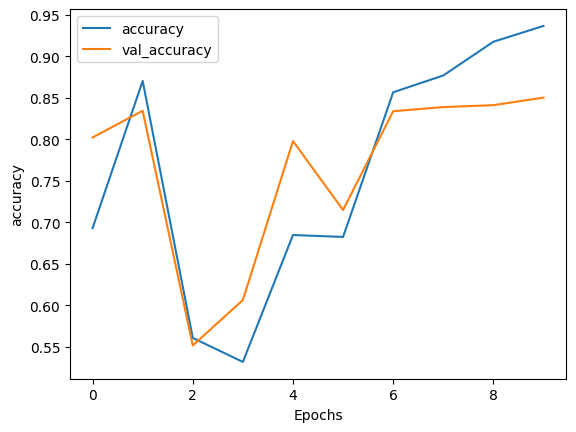

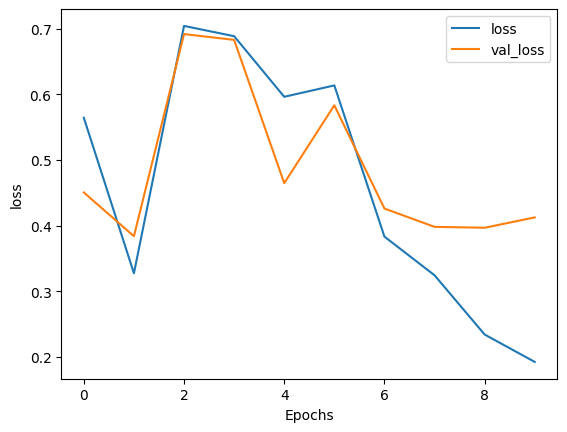

In [6]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you got a first look at using LSTM layers to build Recurrent Neural Networks. You only used a single LSTM layer but this can be stacked as well to build deeper networks. You will see how to do that in the next lab.